# Animation of a single fish that hunts for food

In this notebook, you will learn:

- How to make animation with Python;

- How to simulate the hunting process of a single fish in both ideal and noisy environments

### Basic Setup

In [14]:
import ipyparallel as ipp
import numpy as np
import matplotlib.pyplot as plt

**Attention**! The following command facilitates animation figures.

In [15]:
%matplotlib notebook   

## 1. A single fish moves towards the food source: the ideal case

In this section we will simulate how a single fish moves towards the food source. In addition, we assume the fish knows the precise location of the food source. No estimation process is needed in this section. The main purpose of this section is to help readers get familar with the basic knowledge on 

- the mathematical characterization of how a fish moves towards a target, and 

- how to show the process with animation.

In [16]:
# parameters
delta_t = 3      # time interval
fig_frames = 100 # figures frames
tail_length = 3  # the length of the fish tail

In the following cell, we specify the 2D-dimension of the food location, which is (100, 100).

In [17]:
# target position
w_star = np.array([100,100]).reshape(-1,1)

In the following cell, we specify the initial location of the fish, which is (0, 0).

In [18]:
# initial position
x = np.zeros((2,1))

In the following cell, we define a function to calculate the current uniform velocity of the fish. If $w^o$ denote the target and $x$ denote the current position of the fish, the current uniform velocity of the fish $v$ is calcuated as:

$$v = \frac{w^o - x}{\|w^o - x\|_2}$$

where $\|\cdot\|_2$ denotes the 2-norm.

In [19]:
# uniform velocity
def uniform_velocity(target_position, current_position):
    
    return (target_position - current_position)/np.linalg.norm(target_position - current_position)

Simulation starts in the following cell. We let $x$ and $v$ be the location and velocity of the fish, and $\delta$ be the uniform step-length that fish can move per update. With these notations, a fish will move according to the following dynamic:
    
\begin{equation}
\begin{split}
v^{k+1} & = (w^o - x^{k})/\|w^o - x^{k}\| \\
x^{k+1} & = x^k + \delta \cdot v^{k+1}
\end{split}
\end{equation}

The pair $(x, v)$ will determine the position and the tail's direction (i.e., $-v$). To draw the process how a fist moves towards the food source, we will store the trajectory $\{(x^k, v^k)\}$ and use them to make the animation.

In [20]:
# start simulation
x_record = np.zeros((2, fig_frames))
v_record = np.zeros((2, fig_frames))
for i in range(0, fig_frames):
    v_record[:, [i]] = uniform_velocity(target_position=w_star, current_position=x)
    x = x + delta_t*v_record[:, [i]]
    x_record[:,[i]] = x

The following cell shows an animation in which a fish moves towards the food source. We use the red circle to indicate the fish body, red line segment to indicate the fish tail, and the blue square to indicate the food source.

<IPython.core.display.Javascript object>


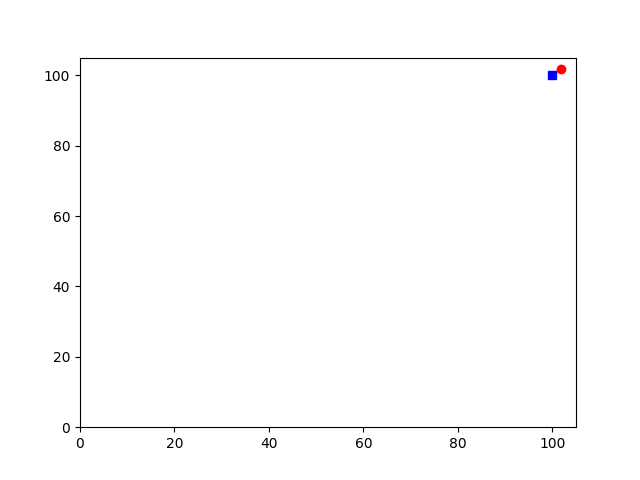

In [21]:
# make animation
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,fig_frames):
    ax.clear()
    x_loc, y_loc = x_record[:,i]
    ax.plot(x_loc, y_loc, 'ro')
    ax.plot([x_loc-tail_length*v_record[0,i],x_loc], [y_loc-tail_length*v_record[1,i], y_loc], 'r-')
    ax.plot(w_star[0], w_star[1], 'bs')
    ax.axis([0, 105, 0, 105])
    fig.canvas.draw()
    plt.pause(0.2)

## 2. A single fish moves towards the food source: the practical case

In real scenario, a fish cannot know the precision location of the food source $w^o$. The main purpose of this section is to 

- explain how a fish will estimate the target position with noisy distance and direction measurements

- show the complete dynamics when $x^o$ is unknown and the fish has to estimate it and run towards it at the same time.

- simulate the process in which a fish moves towards the food even if the food's locaiton is not known in advance

### 2.1 Target estimation and fish movement

In real scenario, a fish cannot know the precise location of the food source $w^o$, and it has to estimate it recursively. According to [[1]](https://asl.epfl.ch/wp-content/uploads/publications/conferences/icassp_2011b.pdf), while a fish cannot directly know $w^o$, it can observe the noisy measurements of the distance $d$ and the direction $u = [\cos(\theta) \sin(\theta)]^T$, see the figure below:

<img src="./images/fish_and_target.png" alt="ibfrun" width="500"/>

When $d$ and $u$ are precise, the relation between $d$, $u$, $w^o$ and $x$ is $d = u^T(w^o - x)$ which is equivalent to $d + u^T x = u^T w^o$. 

The observations $d$ and $u$ in real practice are all noisy, and it typically holds that $d = u^T(w^o - x) + n$ which is equivalent to $d + u^T x = u^T w^o + n$ where $n$ is some noise. As a result, the estimation of the target position $w^o$ can be formulated as the following stochastic least-square problem: 

$$\min_w\quad \frac{1}{2}\mathbb{E}\|d - u^T(w - x)\|^2$$

where $d$, $u$ and $x$ are the measured distance, direction, and current position of the fish, and they are known variables. To solve the above problem, one can refer to stochastic gradient descent (SGD):

$$w^{k+1} = w^k + \gamma u^k \big( d^k - (u^k)^T(w^k - x^k)\big). $$

When the target position $w^{k+1}$ is estimated, the fish can compute the new velocity $v^{k+1}$ and then move to a new position $x^{k+1}$:

\begin{equation}
\begin{split}
v^{k+1} & = (w^{k+1} - x^{k})/\|w^{k+1} - x^{k}\| \\
x^{k+1} & = x^k + \delta \cdot v^{k+1}
\end{split}
\end{equation}

After the fish moves to $x^{k+1}$, it will observe new measurements $u^{k+1}$ and $d^{k+1}$ and start estimating $w^{k+2}$. The process will keep runing until the fish reaches the targeted food source.

### 2.2 Implementation

In [23]:
# parameters
np.random.seed(2021)
delta_t = 3      # time interval
fig_frames = 100 # figures frames
tail_length = 3  # the length of tail

# target
w_target = np.array([100,100]).reshape(-1,1)

# position
X = np.zeros((2,fig_frames))
x_init = np.random.randn(2,1)

In [24]:
w_init = np.random.randn(2,1) # the initial estimate of the target position

The following cell defines a function to let fish observe the noisy measurement of the direction to the target:

In [25]:
# get u
def getU(target_position, current_position, noise = 0.1):
    return (target_position-current_position)/np.linalg.norm(target_position-current_position) + np.random.randn(2,1)*noise

The following cell defines a function to let fish observe the noisy measurement of the distance to the target:

In [26]:
# get d
def getD(u, target_position, current_position, noise = 0.1):
    d = u.T @ (target_position - current_position) 
    return d[0,0] + np.random.randn(1)*noise

Simulation starts in the following cell. 

In [27]:
# start simulation
gamma = 0.5
v_record = np.zeros((2, fig_frames))
x_record = np.zeros((2, fig_frames))
x = x_init.copy()
w = w_init.copy()
for i in range(0, fig_frames):
    
    # get measurements u and d
    u = getU(target_position=w_target, current_position=x, noise=0.5).reshape(-1,1)
    d = getD(u=u, target_position=w_target, current_position=x, noise=0.5)
    
    # estimate target position
    d_estimate = u.T@(w - x)
    w = w + gamma * u * (d - d_estimate[0,0])
    
    # update current location
    v = uniform_velocity(target_position = w, current_position = x)
    x = x + delta_t*v
    
    # record data
    v_record[:, [i]] = v
    x_record[:,[i]] = x

<IPython.core.display.Javascript object>


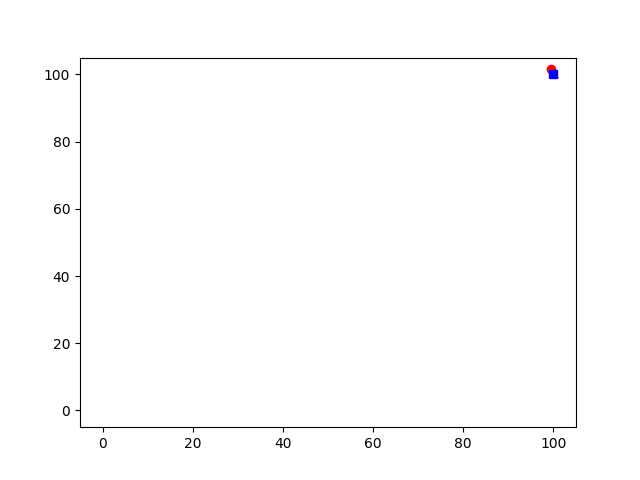

In [29]:
# make animation
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,fig_frames):
    ax.clear()
    x_loc, y_loc = x_record[:,i]
    ax.plot(x_loc, y_loc, 'ro')
    ax.plot([x_loc-tail_length*v_record[0,i],x_loc], [y_loc-tail_length*v_record[1,i], y_loc], 'r-')
    ax.plot(w_star[0], w_star[1], 'bs')
    ax.axis([-5, 105, -5, 105])
    fig.canvas.draw()
    plt.pause(0.2)